In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# define datatype
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    dtype_long = torch.cuda.LongTensor
else:
    dtype = torch.FloatTensor
    dtype_long = torch.LongTensor

# model formulation
class GNN_LMSC_cell(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, units:int, gcn_type: str,
                    batch_size: int,  # this entry is unnecessary, kept only for backward compatibility
                    width=125, depth=4,):
            super(GNN_LMSC_cell, self).__init__()

            self.in_channels = in_channels
            self.out_channels = out_channels
            self.units = units
            self.gcn_type = gcn_type
            self.batch_size = batch_size  # not needed
            self.depth = depth

            start_dim = units + in_channels
            inside_dim = start_dim
            self.qb =  Quadratic_block(inside_dim, width, depth)
        
            if gcn_type == 'GCNConv':
                self.gconv1 = GCN_block(inside_dim, inside_dim, layer = 1)
                self.gconv2 = GCN_block(inside_dim, inside_dim, layer = 1)
            
            if self.depth>0:
                inside_dim = width
            else:
                inside_dim = in_channels

            self.fc_alpha = nn.Linear(inside_dim,units)
            self.fc_beta = nn.Linear(inside_dim,units)

            for m in self.modules():
                if isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        m.bias.data.fill_(0)
                    # m.bias.data.fill_(0)

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
        ) -> torch.FloatTensor:

        # Input strain increment X-> [batch, seq_len, in_dim]
        # Hidden state H -> [batch, node_number, hidden_dim]

        h_t = H
    
        strain_norm = torch.norm(X[:,:,0:6],dim=2)
        x_input = X.clone()
        x_input[:,:,0:6] = (x_input[:,:,0:6].squeeze(1)/(strain_norm + 1e-15)).unsqueeze(1)

        cat_input = torch.cat([x_input.repeat(1,h_t.shape[1],1),h_t], dim = 2)

        # graph embedding
        if self.gcn_type == 'GCNConv':
            G_input1 = self.gconv1(cat_input, edge_index)
            G_input1 = F.relu(G_input1) 
            G_input2 = self.gconv2(cat_input, edge_index)
            G_input2 = F.relu(G_input2) 
        else:
            G_input1 = cat_input
            G_input2 = cat_input

        G_input1 = torch.tanh(self.qb(G_input1))
        G_input2 = torch.tanh(self.qb(G_input2))

        alpha = torch.exp(self.fc_alpha(G_input1))
        beta  = torch.tanh(self.fc_beta(G_input2))

        exp_f =  torch.exp(- alpha * strain_norm.unsqueeze(2).repeat(1,1,self.units))
        h = exp_f * (h_t  - beta) + beta

        return h.squeeze(1)


class GNN_LMSC_Model(nn.Module):
    def __init__(self, args, output_depth=3):
        super(GNN_LMSC_Model, self).__init__()
        self.hidden_dim = args.hidden_dim
        self.seq_len = args.seq_len
        self.output_dim = args.node_output_dim
        self.batch_size = args.batch_size
        self.node_num = args.num_nodes
        self.input_dim = args.node_input_dim
        self.lmsc = GNN_LMSC_cell(args.node_input_dim, args.node_output_dim,
                                   units= args.hidden_dim, gcn_type=args.GCN_type, batch_size=args.batch_size)
        
        if args.out_type == 'FCNN':
            self.decoder = FCNN(args.layers, nn.ReLU)
        else:
            output_depth = args.out_depth
            self.decoder = Quadratic_block(args.hidden_dim, args.node_output_dim, output_depth)

    def forward(self, data):
        '''
        -Data structure
            1. x: input strain increment
            2. edge_index: grain connections in the format of adjacency list
            3. init_ori: initial grain orientations [grain_number, 3] 
        '''
        x, edge_index = data.x.type(dtype), data.edge_index
        edge_index = edge_index.to(device)

        # preprocessing for batch training
        # Input strain increment X-> [batch, seq_len, feature_dim]
        x = x.view(-1,self.seq_len, self.input_dim)
        edge_index = edge_index[:,0:edge_index.size(1)//self.batch_size]

        # Hidden state H -> [batch, node_number, hidden_dim]
        # h0 = torch.zeros(x.size(0), self.node_num, self.hidden_dim)\
        #     .requires_grad_().to(device)
        h0 = torch.zeros(
            x.size(0), self.node_num, self.hidden_dim,
            device=device
        )
        # hidden_out = torch.zeros(x.size(0), self.node_num, x.size(1),\
        #                           self.hidden_dim).requires_grad_().to(device)
        hidden_out = torch.zeros(
            x.size(0), self.node_num, x.size(1), self.hidden_dim,
            device=device
        )
    
        # Assign initial orientation to hidden state
        h0[:,:,0:3] = data.init_ori.view(-1,self.node_num,3).to(device)
        h_last = h0.clone()

        # sequential prediciton
        for i in range(x.size(1)):
            x_input = x[:,i,:].unsqueeze(1).clone()  
            h_last = self.lmsc(x_input, edge_index, H = h_last)
            h_last = h_last.clone()
            hidden_out[:,:,i,:] = h_last.squeeze(1)
        
        # decode the hidden state to Output feature matrix
        # [batch, node_number, hidden_dim] -> [batch, node_number, out_dim]
        hidden_out = self.decoder(hidden_out)
        return hidden_out



class Quadratic_block(nn.Module):
    def __init__(self, input_dim, out_dim, depth):
        super(Quadratic_block, self,).__init__()
        self.modlist1 = nn.ModuleList()
        self.modlist2 = nn.ModuleList()
        self.depth = depth
        for i in range(depth):
            if i == depth-1:
                self.modlist1.append(torch.nn.Linear(input_dim, out_dim, bias=False))
                self.modlist2.append(torch.nn.Linear(input_dim, out_dim, bias=False))
            else:
                self.modlist1.append(torch.nn.Linear(input_dim, input_dim, bias=False))
                self.modlist2.append(torch.nn.Linear(input_dim, input_dim, bias=False))

    def forward(self, x):
        i = 0
        for m in self.modlist1:
            x1 = m(x)
            m2 = self.modlist2[i]
            x2 = m2(x)
            i += 1
            if i < self.depth:
                x1 = torch.tanh(x1)
                x2 = torch.tanh(x2)
            x = x1 * x2
        return x


class GCN_block(nn.Module):
    def __init__(self, in_channels, out_channels, layer,\
                  improved=False, cached=False, add_self_loops=True):
        super(GCN_block, self,).__init__()
        self.modlist = nn.ModuleList()
        self.layer = layer
        for i in range(layer):
            if i == 0:
                self.modlist.append(GCNConv(in_channels, out_channels,\
                                             improved, cached, add_self_loops))
            else:
                self.modlist.append(GCNConv(out_channels, out_channels,\
                                             improved, cached, add_self_loops))

    def forward(self, x, edge_index):
        i = 0
        for m in self.modlist:
            x = m(x, edge_index)
            i += 1
            if i < self.layer:
                x = torch.relu(x)
        return x


class FCNN(torch.nn.Module):
    def __init__(self, layers, activation):
        super(FCNN, self).__init__()
   
        # parameters
        self.depth = len(layers) - 1        
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out 

c:\Users\admin\miniconda3\envs\gnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import h5py

h5_data = h5py.File('demo_dataset_PN8_sq100.hdf5')
all_data = h5_data['data'][:]
print(all_data.shape)

(8, 101, 100, 15)


In [3]:
import numpy as np
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pickle
import h5py

h5_data = h5py.File('demo_dataset_PN8_sq100.hdf5')
all_data = h5_data['data'][:]

print(all_data.shape)

def nx_to_edge_index(G):
    # Ensure nodes are labeled 0..N-1
    G = nx.convert_node_labels_to_integers(G, ordering="sorted")

    # Get edge list
    edges = list(G.edges())

    # Make edges bidirectional
    row = []
    col = []
    for i, j in edges:
        row += [i, j]
        col += [j, i]

    edge_index = torch.tensor([row, col], dtype=torch.long)
    return edge_index

with open("RVE24-n100_edge_feature.pickle", "rb") as f:
    edges = pickle.load(f)

edge_index_tensor = nx_to_edge_index(edges) # edge index tensor

stress = all_data[:, :100, :, 3:9]   # stress from grains
sigma_min = stress.min()
sigma_max = stress.max()

(8, 101, 100, 15)


In [4]:
def normalize_stress(stress, sigma_min, sigma_max):
    return (2 * (stress - sigma_min) / (sigma_max - sigma_min)) - 1

def denormalize_stress(stress_norm, sigma_min, sigma_max):
    return (stress_norm + 1) * (sigma_max - sigma_min) / 2 + sigma_min

def create_data_object(strain_path): # shape (node_num: grains, seq_len: strain increments, feature_dim: variables)
    """
        Inputs
    """
    init_ori = strain_path[:100, 0, 0:3]     # initial orientation of all 100 grains, excluded 101th grain for homogenized RVE
    init_ori = np.deg2rad(init_ori)    # convert to radians
    init_ori = torch.tensor(init_ori, dtype=torch.float32)

    rve_acc_strain = strain_path[100, :, 9:15]    # accumulated strain  of homogenized RVE. Scaled by 100, following the paper.
    strain_incs = np.zeros((100, 6), dtype=np.float32)
    strain_incs[1:] = np.diff(rve_acc_strain, axis=0)    # calculating strain increment, from accumulated strain. First element remains as 0.
    strain_incs *= 100    # Output multiplied by 100, follows the paper.
    strain_incs = torch.tensor(strain_incs, dtype=torch.float32)

    edge_index = edge_index_tensor

    data = Data(
        x=strain_incs,       # shape (seq_len, 6)
        edge_index=edge_index,
        init_ori=init_ori    # shape (100,3)
    )
    return data


def create_ground_truth(strain_path, sigma_min, sigma_max):
    """
    Returns normalized ground truth
    """
    y = np.copy(strain_path[:100, :, :])        # (100, 100, 15), omit 101th grain (RVE homogenized)

    y[:, :, 0:3] = np.deg2rad(y[:, :, 0:3]) # convert orientation to radians

    # normalize stress channels only (3:9)
    y_stress = y[:, :, 3:9]
    y[:, :, 3:9] = normalize_stress(y_stress, sigma_min, sigma_max)

    y = torch.tensor(y, dtype=torch.float32)
    return y

In [5]:
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

train_data = all_data[:6]   # first 6 paths
test_data  = all_data[6:]   # last 2 paths


class StrainPathDataset(Dataset):
    def __init__(self, data, sigma_min, sigma_max):
        self.data = data    # loaded strain path from hdf5 demo dataset (paths, 101, 100, 15)
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        strain_path = self.data[idx]  # (101, 100, 15)

        data = create_data_object(strain_path)
        y = create_ground_truth(strain_path, self.sigma_min, self.sigma_max)

        return data, y

train_dataset = StrainPathDataset(train_data, sigma_min, sigma_max)
test_dataset  = StrainPathDataset(test_data,  sigma_min, sigma_max)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

Define model

In [7]:
from argparse import Namespace

args = Namespace(
    hidden_dim=64,
    seq_len=100,
    node_output_dim=15,     
    batch_size=2,
    num_nodes=100,
    node_input_dim=6,
    GCN_type='GCNConv',
    out_type='Quadratic',   
    out_depth=3,
    layers=None
)

model = GNN_LMSC_Model(args)
model = model.to(device)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskMSELoss(nn.Module):
    def __init__(self, ori_weight=1.0, stress_weight=1.0, acc_strain_weight=1.0):
        super().__init__()
        self.ori_weight = ori_weight
        self.stress_weight = stress_weight
        self.acc_strain_weight = acc_strain_weight

    def forward(self, y_pred, y_true):
        # Split into components
        ori_mse        = F.mse_loss(y_pred[..., 0:3],  y_true[..., 0:3])
        stress_mse     = F.mse_loss(y_pred[..., 3:9],  y_true[..., 3:9])
        acc_strain_mse = F.mse_loss(y_pred[..., 9:15], y_true[..., 9:15])

        # Weighted total loss (scalar, used for backprop)
        total_loss = (
            self.ori_weight        * ori_mse +
            self.stress_weight     * stress_mse +
            self.acc_strain_weight * acc_strain_mse
        )

        # Return both total and components
        return total_loss, {
            "ori_mse": ori_mse,
            "stress_mse": stress_mse,
            "acc_strain_mse": acc_strain_mse,
        }


In [ ]:
# For plotting later
train_history = {
    "total": [],
    "ori": [],
    "stress": [],
    "acc_strain": [],
}

In [ ]:
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 2000

criterion = MultiTaskMSELoss(
    ori_weight=1.0,
    stress_weight=1.0,
    acc_strain_weight=1.0
)

for epoch in range(num_epochs):
    model.train()

    running_total = 0.0
    running_ori = 0.0
    running_stress = 0.0
    running_acc_strain = 0.0
    n_samples = 0  # or use len(train_loader) if you prefer avg per batch

    for data, y_true in train_loader:
        data = data.to(device)
        y_true = y_true.to(device)

        optimizer.zero_grad()

        y_pred = model(data)

        # ⬇️ use the new criterion
        loss, loss_dict = criterion(y_pred, y_true)

        loss.backward()
        optimizer.step()

        batch_size = data.size(0)
        running_total      += loss.item() * batch_size
        running_ori        += loss_dict["ori_mse"].item() * batch_size
        running_stress     += loss_dict["stress_mse"].item() * batch_size
        running_acc_strain += loss_dict["acc_strain_mse"].item() * batch_size
        n_samples          += batch_size

    # Mean losses over the epoch
    epoch_total      = running_total / n_samples
    epoch_ori        = running_ori / n_samples
    epoch_stress     = running_stress / n_samples
    epoch_acc_strain = running_acc_strain / n_samples

    train_history["total"].append(epoch_total)
    train_history["ori"].append(epoch_ori)
    train_history["stress"].append(epoch_stress)
    # train_history["acc_strain"].append(epoch_acc_strain)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Total: {epoch_total:.6e} | "
        f"Ori: {epoch_ori:.6e} | "
        f"Stress: {epoch_stress:.6e} | "
        f"AccStrain: {epoch_acc_strain:.6e}"
    )


Epoch 001 | Total: 4.968719e+00 | Ori: 4.905602e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 002 | Total: 4.968719e+00 | Ori: 4.905602e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 003 | Total: 4.968719e+00 | Ori: 4.905602e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 004 | Total: 4.968719e+00 | Ori: 4.905602e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 005 | Total: 4.968718e+00 | Ori: 4.905601e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 006 | Total: 4.968717e+00 | Ori: 4.905600e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 007 | Total: 4.968715e+00 | Ori: 4.905598e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 008 | Total: 4.968712e+00 | Ori: 4.905595e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 009 | Total: 4.968708e+00 | Ori: 4.905591e+00 | Stress: 6.165939e-02 | AccStrain: 1.457834e-03
Epoch 010 | Total: 4.968701e+00 | Ori: 4.905584e+00 | Stress: 6.165939e-02 | AccStrain: 1.4

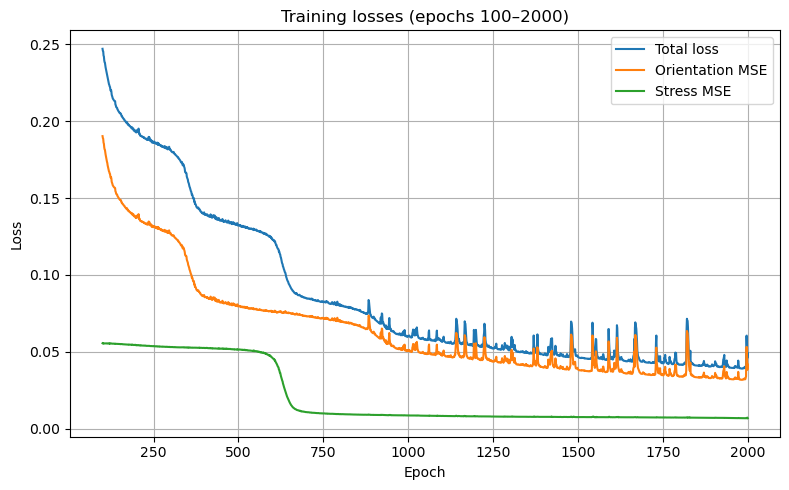

In [41]:
import matplotlib.pyplot as plt

# epochs = range(1, num_epochs + 1)
start_epoch = 100
end_epoch = 2000

epochs = range(start_epoch, end_epoch)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_history["total"][start_epoch:end_epoch], label="Total loss")
plt.plot(epochs, train_history["ori"][start_epoch:end_epoch], label="Orientation MSE")
plt.plot(epochs, train_history["stress"][start_epoch:end_epoch], label="Stress MSE")
# plt.plot(epochs, train_history["acc_strain"][start_epoch:end_epoch], label="Accumulated strain MSE")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training losses (epochs {start_epoch}–{end_epoch})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [32]:
checkpoint = torch.load('630epochs.pt', map_location=device)
model = GNN_LMSC_Model(args).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()   # important for inference


GNN_LMSC_Model(
  (lmsc): GNN_LMSC_cell(
    (qb): Quadratic_block(
      (modlist1): ModuleList(
        (0): Linear(in_features=70, out_features=70, bias=False)
        (1): Linear(in_features=70, out_features=70, bias=False)
        (2): Linear(in_features=70, out_features=70, bias=False)
        (3): Linear(in_features=70, out_features=125, bias=False)
      )
      (modlist2): ModuleList(
        (0): Linear(in_features=70, out_features=70, bias=False)
        (1): Linear(in_features=70, out_features=70, bias=False)
        (2): Linear(in_features=70, out_features=70, bias=False)
        (3): Linear(in_features=70, out_features=125, bias=False)
      )
    )
    (gconv1): GCN_block(
      (modlist): ModuleList(
        (0): GCNConv(70, 70)
      )
    )
    (gconv2): GCN_block(
      (modlist): ModuleList(
        (0): GCNConv(70, 70)
      )
    )
    (fc_alpha): Linear(in_features=125, out_features=64, bias=True)
    (fc_beta): Linear(in_features=125, out_features=64, bias=True)

In [33]:
import torch.nn.functional as F

model.eval()

all_preds = []
all_trues = []

with torch.no_grad():
    for data, y_true in test_loader:
        data = data.to(device)
        y_true = y_true.to(device)

        y_pred = model(data)

        all_preds.append(y_pred.cpu())
        all_trues.append(y_true.cpu())

ori_mse = F.mse_loss(y_pred[..., 0:3], y_true[..., 0:3])
stress_mse = F.mse_loss(y_pred[..., 3:9], y_true[..., 3:9])
acc_strain_mse = F.mse_loss(y_pred[..., 9:15], y_true[..., 9:15])

print("Orientation MSE:", ori_mse.item())
print("Stress MSE:", stress_mse.item())
# print("Accumulated strain MSE:", acc_strain_mse.item())

from sklearn.metrics import r2_score

ori_r2 = r2_score(
    y_true[..., 0:3].cpu().numpy().reshape(-1),
    y_pred[..., 0:3].cpu().numpy().reshape(-1)
)

stress_r2 = r2_score(
    y_true[..., 3:9].cpu().numpy().reshape(-1),
    y_pred[..., 3:9].cpu().numpy().reshape(-1)
)


print("Orientation R²:", ori_r2)
print("Stress R²:", stress_r2)



Orientation MSE: 0.13324175775051117
Stress MSE: 0.011966058984398842
Orientation R²: 0.9484670162200928
Stress R²: 0.7307689785957336


In [35]:
b = 0         # batch index
g = 25       # grain index
t = 50         # timestep


print("Prediction orientation: ", y_pred[b, g, t, 0:3])
print("Ground truth orientation: ", y_true[b, g, t, 0:3])
print('Original truth orientation: ', all_data[b+6, g, t, 0:3])
print('\n')

print("Prediction Cauchy stress: ", y_pred[b, g, t, 3:9])
print("Ground truth Cauchy stress: ", y_true[b, g, t, 3:9])
print("Original truth Cauchy stress: ", all_data[b+6, g, t, 3:9])
print('\n')

print("Prediction accumulated strain: ", y_pred[b, g, t, 9:15])
print("Ground truth accumulated strain: ", y_true[b, g, t, 9:15])
print('Original truth accumulated strain: ', all_data[b+6, g, t, 9:15])
print('\n')

Prediction orientation:  tensor([4.1686, 0.4562, 0.2390])
Ground truth orientation:  tensor([4.0824, 0.5009, 0.2008])
Original truth orientation:  [233.81862  28.69506  11.57775]


Prediction Cauchy stress:  tensor([ 0.5510,  0.1928, -0.0006, -0.0019, -0.0186, -0.0061])
Ground truth Cauchy stress:  tensor([ 0.5561, -0.0344, -0.0232,  0.0525, -0.1076,  0.0333])
Original truth Cauchy stress:  [232.57927 -20.58621 -13.33752  19.87456 -49.07777  10.68471]


Prediction accumulated strain:  tensor([-0.0805, -0.0531,  0.0257, -0.0248, -0.1837, -0.1261])
Ground truth accumulated strain:  tensor([ 0.0883, -0.0584, -0.0156, -0.0305, -0.0066, -0.0068])
Original truth accumulated strain:  [ 0.08857 -0.05914 -0.01499 -0.031   -0.00675 -0.00687]




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_strain_path_from_h5(sample_idx, scaled_by_100=True):
    """
    sample_idx : index of strain path to plot
    """

    strain_path = all_data[sample_idx]        # (101, seq_len, 15)
    rve_acc = strain_path[100, :, 9:15]       # (seq_len, 6)

    if scaled_by_100:
        rve_acc = rve_acc / 100.0

    seq_len = rve_acc.shape[0]
    t = np.arange(seq_len)

    labels = ["ε11", "ε22", "ε33", "γ23", "γ13", "γ12"]

    # --- ε11 vs ε22 strain path ---
    plt.figure()
    plt.plot(rve_acc[:, 0], rve_acc[:, 1], marker="o", markersize=2)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(f"Strain path (sample {sample_idx}): ε11 vs ε22")
    plt.grid(True)

    # --- Accumulated strain vs step ---
    plt.figure()
    plt.plot(t, rve_acc[:, 0], label=labels[0])
    plt.plot(t, rve_acc[:, 1], label=labels[1])
    plt.plot(t, rve_acc[:, 5], label=labels[5])
    plt.xlabel("Step")
    plt.ylabel("Accumulated strain")
    plt.title(f"Accumulated strain vs step (sample {sample_idx})")
    plt.legend()
    plt.grid(True)

    # --- Increment magnitude ---
    incs = np.zeros_like(rve_acc)
    incs[1:] = np.diff(rve_acc, axis=0)
    inc_norm = np.linalg.norm(incs, axis=1)

    plt.figure()
    plt.plot(t, inc_norm)
    plt.xlabel("Step")
    plt.ylabel("||Δε||")
    plt.title(f"Strain increment magnitude (sample {sample_idx})")
    plt.grid(True)

    plt.show()


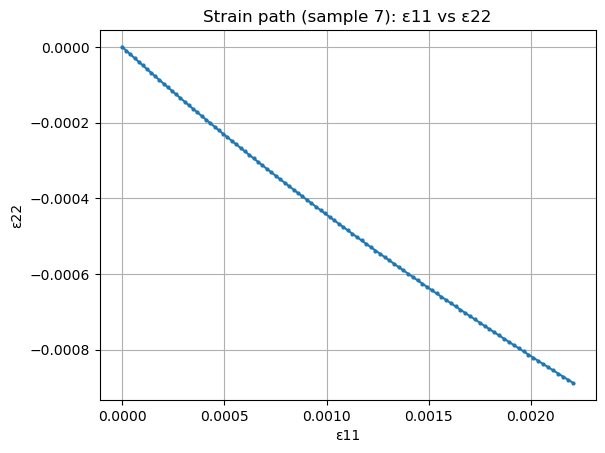

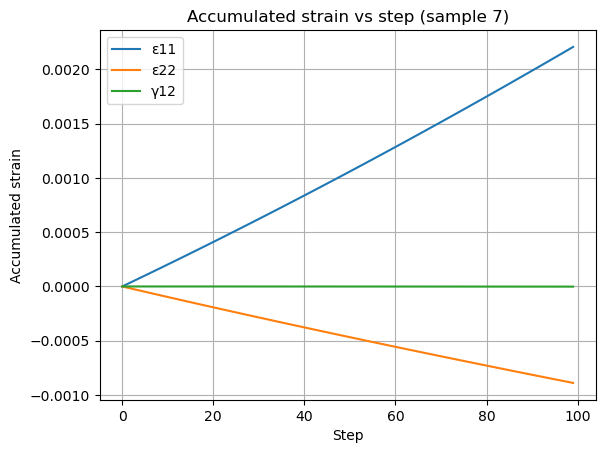

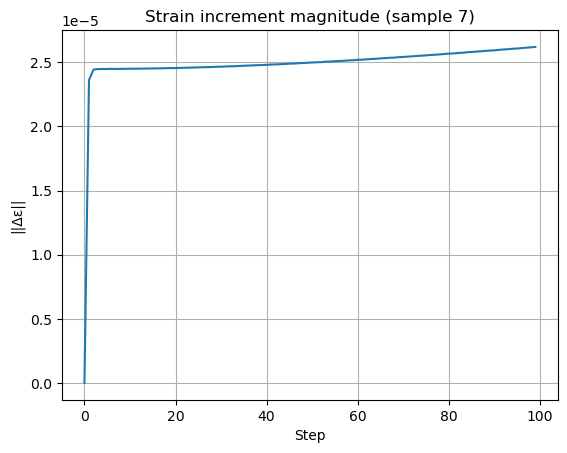

In [26]:
plot_strain_path_from_h5(7, True)

In [ ]:
import h5py

h5_data = h5py.File('demo_dataset_PN8_sq100.hdf5')
all_data = h5_data['data'][:]
# print(all_data.shape)

test_data = all_data[1]

# orig_ori = test_data[g, t, ]
print(test_data[g, t, ])

# test = all_data[:100, :, :]        # (100, 100, 15)
test = all_data[7, g, t, 3:9]        # (100, 100, 15)

# normalize stress channels only (3:9)
# test_stress = test[:, :, 3:9]
normalised_stress = normalize_stress(test, sigma_min, sigma_max)

# print(normalised_stress)
# print(sigma_min, sigma_max)

processed_data = create_data_object(test_data)
# print(processed_data.x)

[-390.3163  -110.51343   82.76505   -2.18077   44.80113  -60.64523]


In [48]:
from torch import device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data, y_true = next(iter(loader))
data = data.to(device)
y_true = y_true.to(device)

y_pred = model(data)

print(y_pred.shape)
# print(data.x.shape)
print(y_true.shape)


torch.Size([2, 100, 100, 15])
torch.Size([2, 100, 100, 15])


In [ ]:
import pickle
import networkx as nx
import torch

with open("RVE24-n100_edge_feature.pickle", "rb") as f:
    edges = pickle.load(f)


def nx_to_edge_index(G):
    # Ensure nodes are labeled 0..N-1
    G = nx.convert_node_labels_to_integers(G, ordering="sorted")

    # Get edge list
    edges = list(G.edges())

    # Make edges bidirectional
    row = []
    col = []
    for i, j in edges:
        row += [i, j]
        col += [j, i]

    edge_index = torch.tensor([row, col], dtype=torch.long)
    return edge_index


torch.Size([2, 1504])
0 2
2 0
0 12
12 0
0 13
13 0
0 17
17 0
0 30
30 0
0 34
34 0
0 40
40 0
0 46
46 0
0 50
50 0
0 57
57 0
0 65
65 0
0 68
68 0
0 72
72 0
0 81
81 0
0 89
89 0
0 92
92 0
0 97
97 0
2 4
4 2
2 17
17 2
2 18
18 2
2 34
34 2
2 36
36 2
2 40
40 2
2 59
59 2
2 60
60 2
2 68
68 2
2 74
74 2
2 79
79 2
2 82
82 2
2 85
85 2
2 89
89 2
2 98
98 2
12 13
13 12
12 15
15 12
12 30
30 12
12 31
31 12
12 37
37 12
12 38
38 12
12 57
57 12
12 61
61 12
12 72
72 12
12 80
80 12
12 91
91 12
12 95
95 12
12 97
97 12
13 5
5 13
13 37
37 13
13 38
38 13
13 46
46 13
13 57
57 13
13 58
58 13
13 68
68 13
13 81
81 13
13 85
85 13
13 92
92 13
13 97
97 13
13 99
99 13
17 18
18 17
17 24
24 17
17 34
34 17
17 48
48 17
17 50
50 17
17 65
65 17
17 68
68 17
17 74
74 17
17 82
82 17
30 11
11 30
30 26
26 30
30 31
31 30
30 39
39 30
30 50
50 30
30 57
57 30
30 61
61 30
30 72
72 30
30 76
76 30
30 78
78 30
30 91
91 30
30 98
98 30
34 4
4 34
34 32
32 34
34 37
37 34
34 40
40 34
34 50
50 34
34 56
56 34
34 59
59 34
34 60
60 34
34 61
61 34
34 72


In [104]:
# data_obj = create_data_object(data[0])

# print(data_obj.x.shape)

# for batch in loader:
#     print("x:", batch.x.shape)
#     print("edge_index:", batch.edge_index.shape)
#     print("init_ori:", batch.init_ori.shape)
#     print("batch vector:", batch.batch.shape)
#     break

print(path0[0, :5, 0:3])
print(np.deg2rad(path0[0, :5, 0:3]))              # convert to radians

[[228.0067   18.6711   15.5926 ]
 [227.94653  18.63262  15.63924]
 [227.88055  18.59222  15.68936]
 [227.80481  18.55232  15.74941]
 [227.7251   18.51262  15.81334]]
[[3.9794676  0.32587218 0.2721422 ]
 [3.9784174  0.32520056 0.27295622]
 [3.9772658  0.32449546 0.27383098]
 [3.975944   0.32379907 0.27487904]
 [3.9745526  0.3231062  0.27599484]]


In [98]:
import numpy as np

# for path in data:
#     print(path[13, 0, 9:15])

#     # print(len(path[0, :, 9:15]))

# print(data[0, :, 0, 9:15])

path0 = data[0]

print(path0[:100, 0, 9:15])
# print(np.diff(path0[100, :, 9:15][:3], axis=0))


test = [[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4]]
# print(np.diff(test))

arr = np.array([[1, 2],
                [2, 3]])

# print(arr.shape)  # (2, 2)

# print(np.diff(arr, axis=0))

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

In [26]:
edge_index = torch.tensor([
    [i for i in range(99) for _ in (0,)],
    [i+1 for i in range(99)]
], dtype=torch.long)

print(edge_index)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
         55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
         91, 92, 93, 94, 95, 96, 97, 98, 99]])
